<a href="https://www.kaggle.com/code/leomauro/anomaly-detection-streaming-data-evaluation?scriptVersionId=90736265" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Anomaly Detection - Streaming Data (Evaluation)

This notebook presents a few unsupervised algorithms to detect anomaly in real streaming data, such as seasonal KPIs. "Streaming data is data that is continuously generated by different sources. Such data should be processed incrementally using stream processing techniques without having access to all of the data" [Wikipedia](https://en.wikipedia.org/wiki/Streaming_data). We are going to experiment Anomaly Detection in [Benchmark: Labeled Anomaly Detection TS](https://www.kaggle.com/caesarlupum/benchmark-labeled-anomaly-detection-ts). In the end, I hope you are going to be able to apply this family of algorithms.


> **Summary** - Unsupervised Anomaly Detection in real Streaming Data.   
> Content for intermediate level in Machine Learning and Data Science!   

**Notes**
- This notebook is an extension of [Anomaly Detection - Streaming Data](https://www.kaggle.com/leomauro/anomaly-detection-streaming-data/)   
- See another extension with many other algorithms [Anomaly Detection - Streaming Data (Extended)](https://www.kaggle.com/neomatrix369/anomaly-detection-streaming-data-extended/)

<a id='ToC'></a>
## Table of Contents
- [Data Exploration](#data)
- [Streaming Anomaly Detection](#anomaly)
    - [Moving Average](#ma)
    - [Exponential Moving Average](#ema)
- [Conclusion](#conclusion)

---
<h3><a href="https://medium.com/wearesinch/simple-anomaly-detection-algorithms-for-streaming-data-machine-learning-92cfaeb6f43b">Click here to read to the Medium blog post</a></h3>

![](https://miro.medium.com/max/1400/1*Kh3wXbIA2oKHc8qiIy3v0g.png)

<a id="data"></a>

---
# Data Exploration

We are using [Benchmark: Labeled Anomaly Detection TS](https://www.kaggle.com/caesarlupum/benchmark-labeled-anomaly-detection-ts) data source that presents a corpus of four seasonal KPIs over time, designed to provide data for research in streaming anomaly detection. Also, in this section, we are going to explore the data using the visualizations proposed by [Anomaly Detection - Visualizations](https://www.kaggle.com/docxian/anomaly-detection-visualizations) notebook.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/benchmark-labeled-anomaly-detection-ts/server_res_eth1out_curve_61.csv
/kaggle/input/benchmark-labeled-anomaly-detection-ts/rver_res_eth1out_curve_6.csv
/kaggle/input/benchmark-labeled-anomaly-detection-ts/g.csv
/kaggle/input/benchmark-labeled-anomaly-detection-ts/cpu4.csv


We are going to use two datasets:

- `/kaggle/input/benchmark-labeled-anomaly-detection-ts/g.csv`
- `/kaggle/input/benchmark-labeled-anomaly-detection-ts/cpu4.csv`

In [3]:
# first dataset
df1 = pd.read_csv('../input/benchmark-labeled-anomaly-detection-ts/cpu4.csv')
df1 = df1.sort_values(by='timestamp', ascending=True)
df1 = df1.replace({'label': {0.0: False, 1.0: True}})

# second dataset
df2 = pd.read_csv('../input/benchmark-labeled-anomaly-detection-ts/g.csv')
df2 = df2.sort_values(by='timestamp', ascending=True)
df2 = df2.replace({'label': {0.0: False, 1.0: True}})

df1.head(3)

,timestamp,value,label
0,1469376000,0.847300,False
1,1469376300,-0.036137,False
2,1469376600,0.074292,False


## Frequency of Anomalies

How many anomalies do we have in each dataset?

In [4]:
print('Frequencies:')
print(df1.label.value_counts(normalize=True), '\n')
print(df2.label.value_counts(normalize=True))

Frequencies:
False    0.988103
True     0.011897
Name: label, dtype: float64 

False    0.941314
True     0.058686
Name: label, dtype: float64


## Anomalies in the Dataset

Let's visualize the datasets.

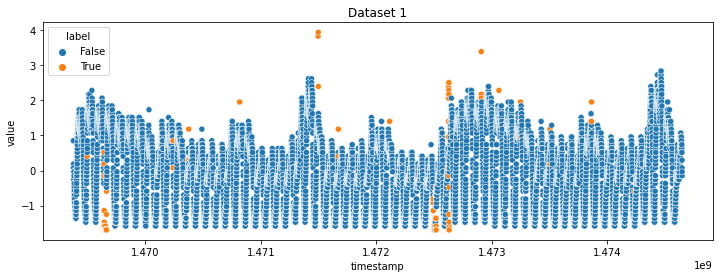

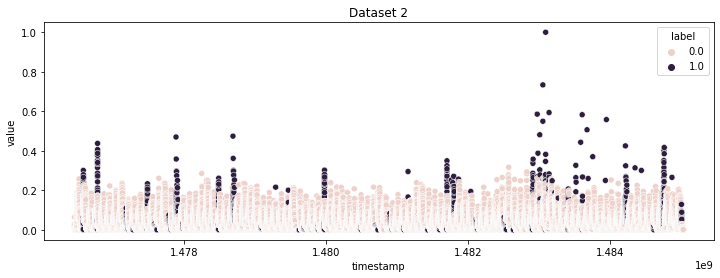

In [5]:
plt.figure(figsize=(12,4))
plt.title('Dataset 1')
sns.scatterplot(data=df1, x="timestamp", y="value", hue="label")
plt.show()

plt.figure(figsize=(12,4))
plt.title('Dataset 2')
sns.scatterplot(data=df2, x="timestamp", y="value", hue="label")
plt.show()

We cannot see what is happening. So let's zoom in on the data... therefore, we can clearly visualize the anomalies in the Streaming Data.
- We are going to explore only 300 points of each dataset

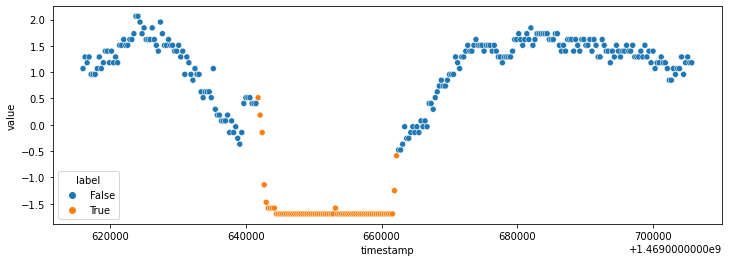

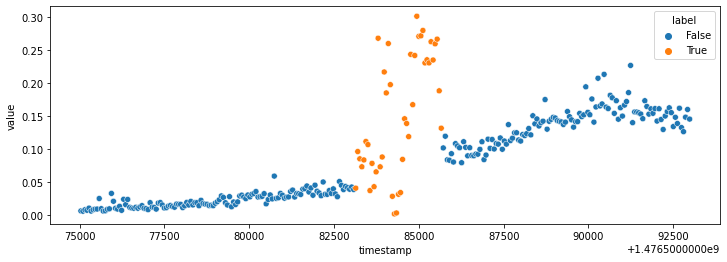

In [6]:
df1_zoom = df1[800:1100]
plt.figure(figsize=(12,4))
sns.scatterplot(data=df1_zoom, x="timestamp", y="value", hue="label")
plt.show()

df2_zoom = df2[1900:2200]
plt.figure(figsize=(12,4))
sns.scatterplot(data=df2_zoom, x="timestamp", y="value", hue="label")
plt.show()

<a href='#ToC'><span class="label label-info" style="font-size: 125%">Back to Table of Contents</span></a>

<a id="anomaly"></a>

---
# Streaming Anomaly Detection
Do you want to monitor your data and detect anomalies on fly? We are going to see a few algorithms for that:

- Streaming Moving Average
- Streaming Exponential Average

In [7]:
def plot_anomalies(df, algorithm, parameters, dumping=False):
    '''Plot the Streaming Data (an Anomalies)'''
    X = df.timestamp
    Y = df.value
    # predict anomalies
    model = algorithm(**parameters)
    preds = [model.detect(i, v, dumping=True) for i, v in zip(X, Y)]
    pred, values, stds = tuple(zip(*preds))
    # plot the results
    plt.figure(figsize=(12,4))
    model_name = algorithm.__name__
    plt.title(f'Anomaly Detection - {model_name}')
    af  = pd.DataFrame(data={'x':X, 'value':Y, 'pred':pred})
    af2 = pd.DataFrame(data={'x':X, 'value':values, 'pred':pred, 'std': stds})
    af2['ymin'] = af2['value'] - af2['std']
    af2['ymax'] = af2['value'] + af2['std']
    size = (af.pred.astype(int)+1) * 40
    sns.scatterplot(data=af, x='x', y='value', hue='pred', s=size)
    if dumping: plt.fill_between(af2.x, af2.ymin, af2.ymax, facecolor='green', alpha=0.2)
    plt.show()

<a id="ma"></a>
## Moving Average

**Moving Average** is the most common type of average used in Time Series problems. We perform the sum of recent data points and divide them by the time period. Further, we simply check if the new record is far from the expected value. The expected value range is computed using the formula `Moving Average + standard deviation * threshold`; if it is out of the expected value range, we report as an anomaly.

In [8]:
class StreamingMovingAverage:
    '''Moving Average algorithm'''
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html

    def __init__(self, threshold=1.0) -> None:
        # Parameters
        self.max_deviation_from_expected = threshold
        self.min_nof_records_in_model = 3
        self.max_nof_records_in_model = 3 * self.min_nof_records_in_model

    def detect(self, timestamp: int, value: float, dumping: bool=False) -> bool:
        '''Detect if is a Anomaly'''
        self._update_state(timestamp, value)
        expected_value = self._expected_value(timestamp)
        # is there enough data and is not NaN value
        response, curr_value, deviation = False, value, 0.0
        if self._enough_data() and not np.isnan(expected_value):
            # is the value out of the boundary? when it decrease
            curr_value = expected_value
            deviation = self._standard_deviation() * self.max_deviation_from_expected
            # when it is higher than expected
            if expected_value + deviation < value or\
               expected_value - deviation > value:
                response = True
        # dumping or not
        if dumping: return (response, curr_value, deviation)
        else: return response

    def _update_state(self, timestamp: int, value: float) -> None:
        '''Update the model state'''
        # check if it is the first time the model is run or if there is a big interval between the timestamps
        if not hasattr(self, 'previous_timestamp'):
            self._init_state(timestamp)
        # update the model state
        self.previous_timestamp = timestamp
        self.data_streaming.append(value)
        # is there a lot of data? remove one record
        if len(self.data_streaming) > self.max_nof_records_in_model:
            self.data_streaming.pop(0)

    def _init_state(self, timestamp: int) -> None:
        '''Reset the parameters'''
        self.previous_timestamp = timestamp
        self.data_streaming = list()

    def _enough_data(self) -> bool:
        '''Check if there is enough data'''
        return len(self.data_streaming) >= self.min_nof_records_in_model

    def _expected_value(self, timestamp: int) -> float:
        '''Return the expected value'''
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        many = self.min_nof_records_in_model
        return data.rolling(many, min_periods=1).mean().iloc[-1]

    def _standard_deviation(self) -> float:
        '''Return the standard deviation'''
        data = self.data_streaming
        return np.std(data, axis=0)

    def get_state(self) -> dict:
        '''Get the state'''
        self_dict = {key: value for key, value in self.__dict__.items()}
        return pickle.dumps(self_dict, 4)

    def set_state(self, state) -> None:
        '''Set the state'''
        _self = self
        ad = pickle.loads(state)
        for key, value in ad.items():
            setattr(_self, key, value)

### Exploring the Data

You can note that the **Moving Average** is too sensitive to data. Any abrupt change it is notified as _anomaly_. In this sense, for each streaming data, you have to fit the `threshold`. However, remember thar a high `threshold` cannot find any anomaly. 

Also, we can note that when the data behaviour change, the algorithm is able to quickly adapt and learn the new behavior. Another advantage of this algorithm is it only notify the anomaly once, and the sequential anomaly data (with similar behavior) is ignored due to the sensibility of the algorithm, avoiding multiples "anomaly alerts".

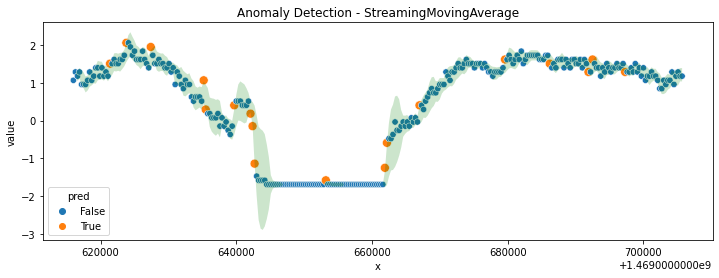

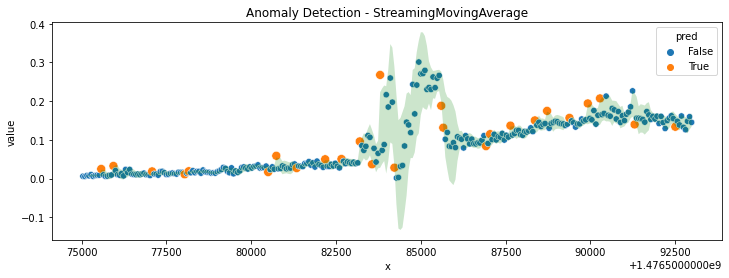

In [9]:
parameters = {'threshold': 1.5}
plot_anomalies(df1_zoom, StreamingMovingAverage, parameters, dumping=True)

parameters = {'threshold': 1.5}
plot_anomalies(df2_zoom, StreamingMovingAverage, parameters, dumping=True)

<a href='#ToC'><span class="label label-info" style="font-size: 125%">Back to Table of Contents</span></a>

-----
<a id="ema"></a>

## Exponential Moving Average

**Exponential Moving Average** focuses more on recent data by assigning more weight to new data points; so, they are weigted by timestamp - most recent has more importance. Further, we simple check if the new record is far from the expected value. The expected value range is computed using the formula `Exponential Moving Average + standard deviation * threshold`; if it is out of the expected value range, we report as an anomaly.

Also, the Exponential Moving Average needs a parameter called `alpha` that determines the importance of the last record, and its value is decreased for the next records. For example, if `alpha=0.5`: the record-1 has 50% of importance, the record-2 has 30% of importance, and so on. Thus, this weighted algorithm enables smooth the expected value.

In [10]:
class StreamingExponentialMovingAverage(StreamingMovingAverage):
    '''Exponential Weighted Moving Average (EWMA) algorithm'''
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.ewm.html

    def __init__(self, threshold=1.0, alpha=0.3) -> None:
        super().__init__()
        # Parameters
        self.max_deviation_from_expected = threshold
        self.alpha = alpha

    def _enough_data(self) -> bool:
        '''Check if there is enough data'''
        return len(self.data_streaming) > 0

    def _expected_value(self, timestamp: int) -> float:
        '''Return the expected value'''
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        return data.ewm(alpha=self.alpha, adjust=True).mean().iloc[-1]


### Exploring the Data

You can note that the **Exponential Moving Average** is more smooth to changes than the simple **Moving Average**. However, this algorithm has two parameters to be defined by the user, they are `threshold` and `alpha`.

Again, we can note that when the data behaviour change, the algorithm is able to quickly adapt and learn the new behavior. Another advantage of this algorithm is it only notify the anomaly once, and the sequential anomaly data (with similar behavior) is ignored due to the sensibility of the algorithm, avoiding multiples "anomaly alerts".

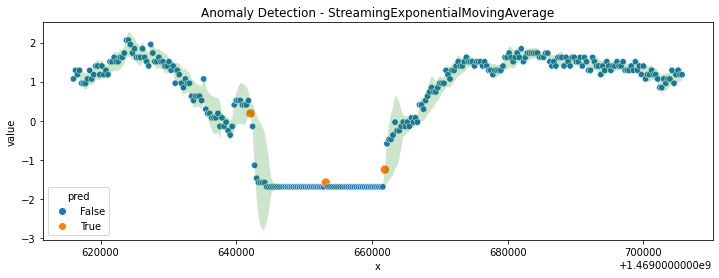

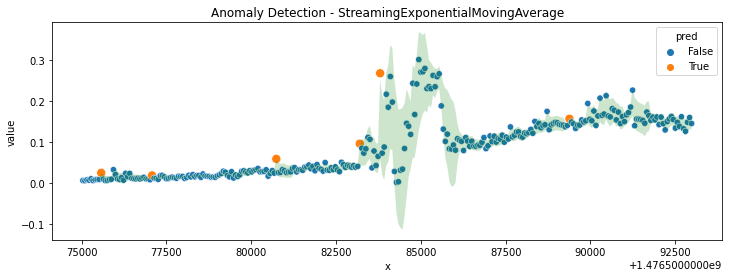

In [11]:
parameters = {'threshold': 1.5, 'alpha': 0.45}
plot_anomalies(df1_zoom, StreamingExponentialMovingAverage, parameters, dumping=True)

parameters = {'threshold': 1.5, 'alpha': 0.45}
plot_anomalies(df2_zoom, StreamingExponentialMovingAverage, parameters, dumping=True)

<a href='#ToC'><span class="label label-info" style="font-size: 125%">Back to Table of Contents</span></a>

<a id="conclusion"></a>

---
# Conclusion

(1) We can see that **Exponential Moving Average** smooths the prediction better than the simple **Moving Average**. For the first dataset, the algorithm was able to detect the exact point of the anomaly and quickly adjust your prediction behaviour, avoiding multiples "sequential anomaly alerts".


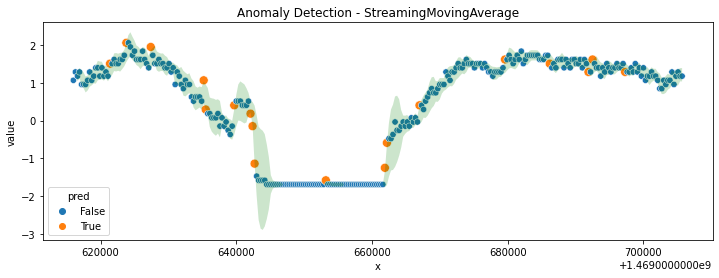

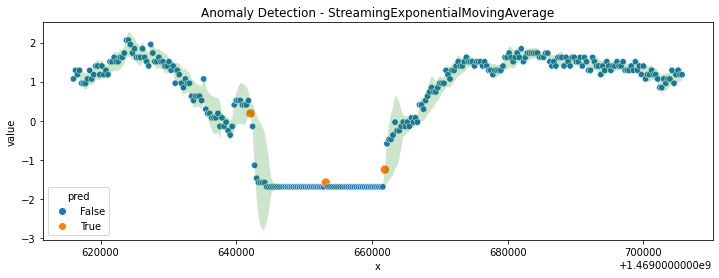

In [12]:
parameters = {'threshold': 1.5}
plot_anomalies(df1_zoom, StreamingMovingAverage, parameters, dumping=True)

parameters = {'threshold': 1.5, 'alpha': 0.45}
plot_anomalies(df1_zoom, StreamingExponentialMovingAverage, parameters, dumping=True)

(2) Again, we can see that **Exponential Moving Average** smooths the prediction better than the simple **Moving Average**. However, the second dataset was more difficult than the first one, due to the high variation in the data. Anyway, the algorithm was able to detect the anomaly point, also produce a few false negative.


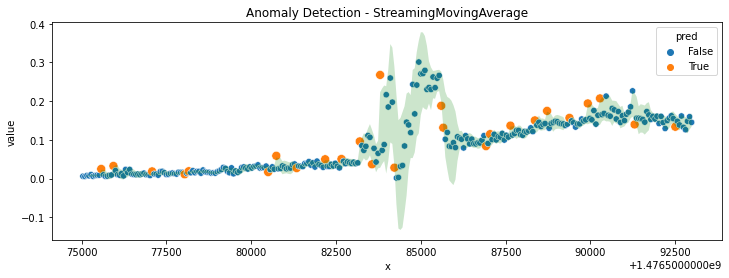

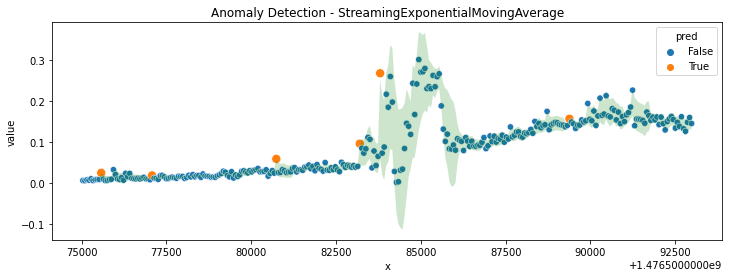

In [13]:
parameters = {'threshold': 1.5}
plot_anomalies(df2_zoom, StreamingMovingAverage, parameters, dumping=True)

parameters = {'threshold': 1.5, 'alpha': 0.45}
plot_anomalies(df2_zoom, StreamingExponentialMovingAverage, parameters, dumping=True)

<a href='#ToC'><span class="label label-info" style="font-size: 125%">Back to Table of Contents</span></a>